# Demodulación y Tasa de Error de Bit de Datos Experimentales

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
from numpy import pi
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Carga de archivos

- 14.3dB => $0$
- 15.3dB => $\pi$
- 16.3dB => $\pi$
- 17.8dB => $\pi$
- 19.3dB => $\pi$
- 21.3dB => $\pi$
- 23.3dB => $\pi$
- 26.3dB => $\pi /2$
- 28.3dB => $3\pi /2$
- 31.3dB => $\pi$
- 36.3dB => $\pi /2$

In [2]:
OSNR = [14.3, 15.3, 16.3, 17.8, 19.3, 21.3, 23.3, 26.3, 28.3, 31.3, 36.3]
df_rx = pd.DataFrame()
for i in OSNR:
    rot = 0
    if (i == 28.3):
        rot = 3 * pi / 2
    elif (i == 26.3) or (i == 36.3):
        rot = pi / 2
    elif (i == 14.3):
        rot = 0
    else:
        rot = pi
    data_rx = sio.loadmat(f'Datos\\16QAM_3x16GBd_consY{i}dB.mat')
    data_rx = 3 * (data_rx['const_Y'] - data_rx['const_Y'].mean()) / data_rx['const_Y'].std()
    df_rx[f'Data_{i}dB'] = np.transpose(data_rx * np.exp(1j * rot)).flatten()
df_rx.head()

,Data_14.3dB,Data_15.3dB,Data_16.3dB,Data_17.8dB,Data_19.3dB,Data_21.3dB,Data_23.3dB,Data_26.3dB,Data_28.3dB,Data_31.3dB,Data_36.3dB
0,2.937576+3.394176j,-2.786884-0.627103j,-3.130784-0.947652j,3.215822-1.136120j,-2.556796-2.227486j,1.010017+2.793016j,0.794928+2.997837j,1.083147-1.159303j,1.409522+2.914064j,1.067579+1.253951j,0.992194+2.515151j
1,0.553878-2.866198j,-2.104499-2.725319j,-3.363163-2.700044j,1.243624-3.814304j,-0.630683-1.085485j,2.470131+2.956489j,-0.935616-2.810580j,-1.040671+2.733549j,3.139095-2.961636j,0.500978+2.868988j,2.873063+1.039816j
2,-1.972350-0.826754j,-2.454458+1.201009j,-0.693959+3.486653j,3.268285+2.587314j,3.328637+0.923141j,2.404895+2.812937j,0.846529+0.851141j,-2.600552+2.994610j,-1.166931-0.538810j,-0.722500-0.697163j,3.003888+1.061219j
3,1.699220+0.594390j,0.025810-2.610029j,0.474526-1.025647j,0.878752+0.189450j,3.141076-2.605799j,0.979540+2.942178j,-2.803784-2.409777j,2.700856+0.839373j,3.012065-2.719527j,2.866760-3.304368j,2.942409-2.773518j
4,-2.707107+1.746102j,-1.038677-0.752483j,2.406400-1.002598j,2.762454+0.333475j,3.064086-0.824050j,-2.892537+1.020613j,1.112006+2.415710j,-2.962827+2.974880j,0.995220-0.995911j,-1.067548+2.930045j,-2.808033-2.666020j


In [3]:
# Datos experimentales transmitidos (Tx)
data_tx = sio.loadmat('Datos\\2x16QAM_16GBd.mat')
data_tx = data_tx['Constellation'].flatten()[0][0]
df_tx = pd.DataFrame(np.transpose(data_tx), columns = ['tx'])
df_tx.head()

,tx
0,3.0+3.0j
1,-3.0-3.0j
2,3.0-1.0j
3,-3.0+3.0j
4,-3.0+3.0j


## Preparación de los datos

In [4]:
Xr = [np.real(df_rx[f'Data_{i}dB']) for i in OSNR]
Xi = [np.imag(df_rx[f'Data_{i}dB']) for i in OSNR]

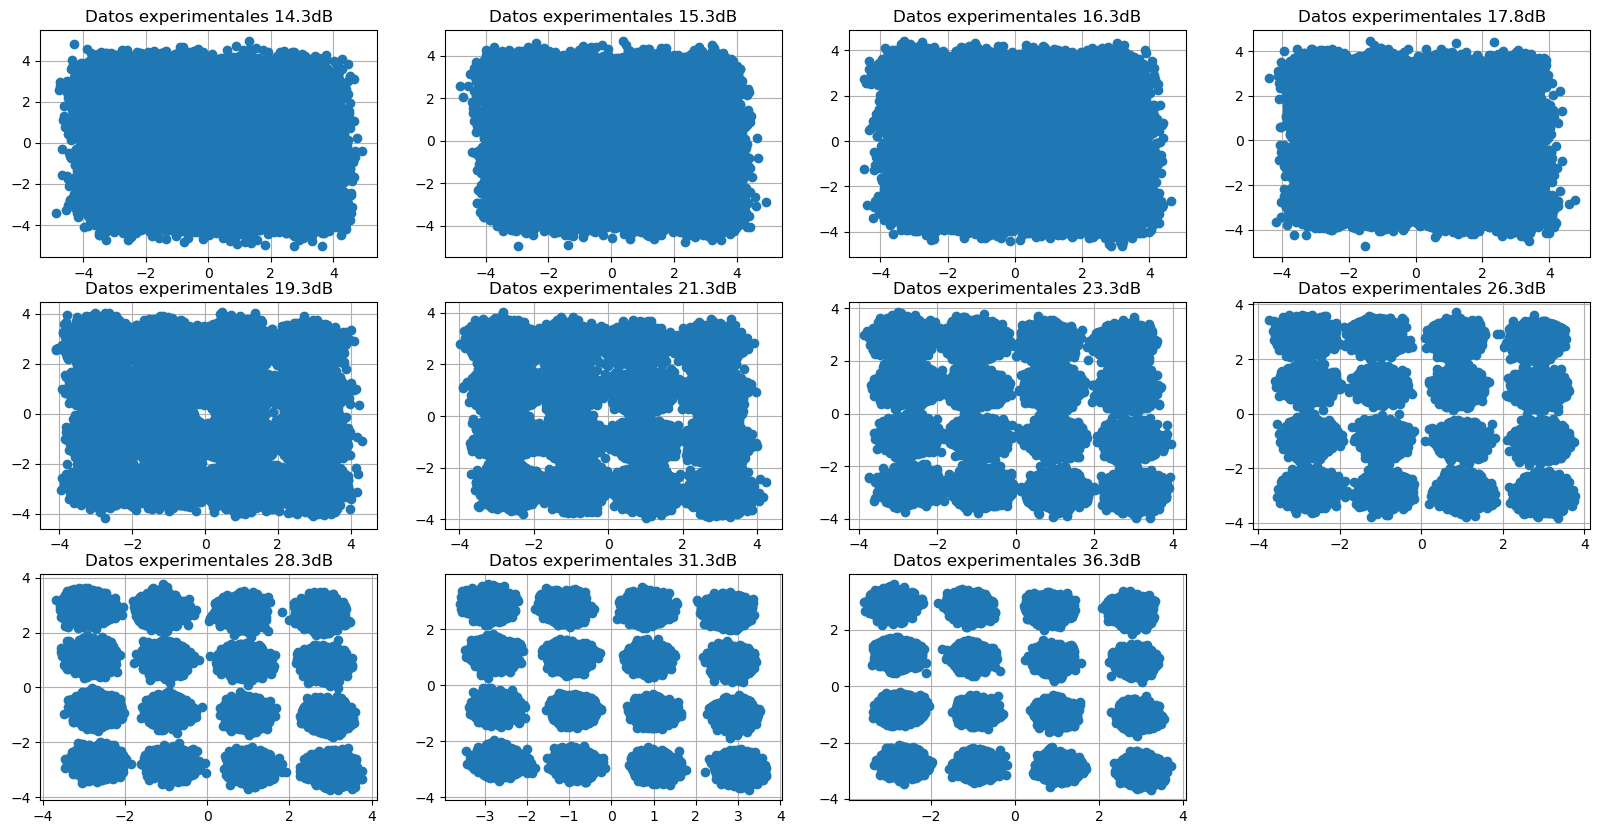

In [5]:
plt.figure(figsize = (20, 10))
for it, item, in enumerate(OSNR):
    plt.subplot(3, 4, it + 1)
    plt.plot(Xr[it], Xi[it], 'o')
    plt.title(f'Datos experimentales {item}dB')
    plt.grid()
plt.show()

In [6]:
X = [np.transpose(np.array([Xr[i], Xi[i]])) for i in range(len(OSNR))]

## Creación del modelo de Machine Learning

In [7]:
def symbol_error_rate(sym_rx, sym_tx):
  error = 0
  for i, rx in enumerate(sym_rx):
    if (rx != sym_tx[i]):
      error += 1
  SER = error / len(sym_tx)
  return SER, error

def bit_error_rate(sym_rx, sym_tx):
  sym_rx_bin = ''.join([f'{sym:04b}' for sym in sym_rx])
  sym_tx_bin = ''.join([f'{sym:04b}' for sym in sym_tx])

  error = 0
  for i in range(len(sym_tx_bin)):
    if (sym_rx_bin[i] != sym_tx_bin[i]):
      error += 1
  BER = error / len(sym_tx_bin)
  return BER, error

def sync_signals(trama_tx, trama_rx):
  tx = np.concatenate((trama_tx, trama_tx))
  corr = np.abs(np.correlate(np.abs(tx) - np.mean(np.abs(tx)),
                             np.abs(trama_rx) - np.mean(np.abs(trama_rx)), mode='full'))
  delay = np.argmax(corr) + 1 - len(trama_rx)
  #print(f'El retraso es de {delay} posiciones')
  trama_sync = tx[delay:]
  trama_sync = trama_sync[:len(trama_rx)]
  return trama_sync

def demodulate(arr):  
  y = []
  for i in arr:
    if (i == -3+3j):
      y.append(0)
    elif (i == -3+1j):
      y.append(1)
    elif (i == -3-3j):
      y.append(2)
    elif (i == -3-1j):
      y.append(3)
    elif (i == -1+3j):
      y.append(4)
    elif (i == -1+1j):
      y.append(5)
    elif (i == -1-3j):
      y.append(6)
    elif (i == -1-1j):
      y.append(7)
    elif (i == 3+3j):
      y.append(8)
    elif (i == 3+1j):
      y.append(9)
    elif (i == 3-3j):
      y.append(10)
    elif (i == 3-1j):
      y.append(11)
    elif (i == 1+3j):
      y.append(12)
    elif (i == 1+1j):
      y.append(13)
    elif (i == 1-3j):
      y.append(14)
    elif (i == 1-1j):
      y.append(15)
  return y

In [8]:
num_clusters = 16
cent_init = np.array([[-3,3], [-3,1], [-3,-3],[-3,-1],
                    [-1,3],[-1,1],[-1,-3],[-1,-1],
                    [3,3],[3,1],[3,-3],[3,-1],
                    [1,3],[1,1],[1,-3],[1,-1]])

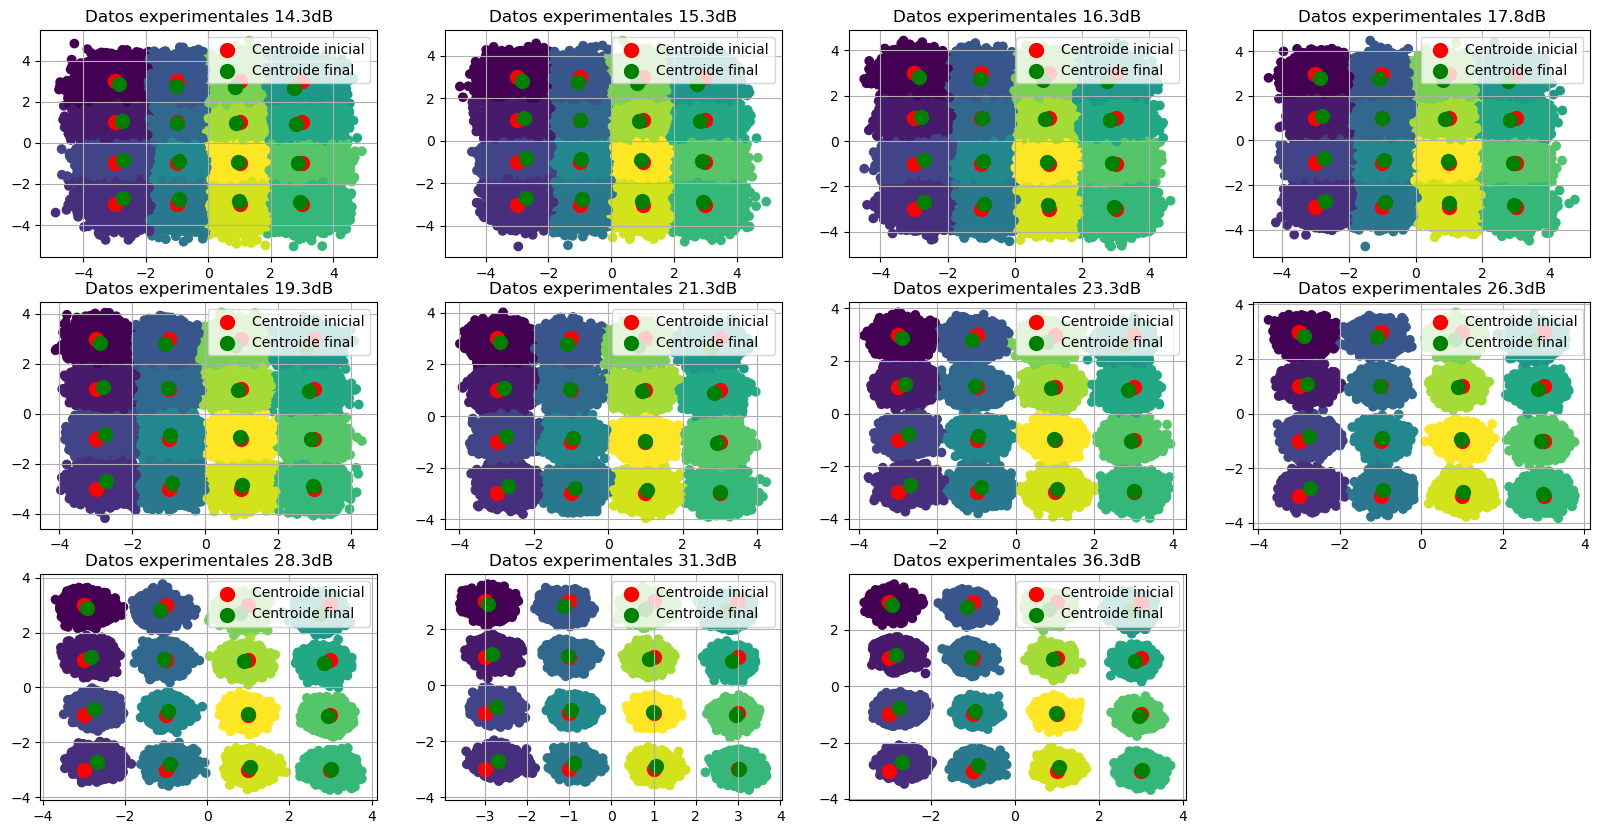

In [9]:
ber = []
plt.figure(figsize = (20, 10))
for i, item in enumerate(OSNR):
    model = KMeans(n_clusters = num_clusters, init = cent_init, n_init = 1)
    model.fit(X[i])

    plt.subplot(3, 4, i + 1)
    plt.scatter(Xr[i], Xi[i], c = model.labels_, marker = 'o')
    plt.scatter(cent_init[:, 0], cent_init[:, 1],
                s = 100, label = 'Centroide inicial',
                marker = 'o', color = 'red')
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
                s = 100, label = 'Centroide final', marker = 'o', color = 'green')
    plt.title(f'Datos experimentales {item}dB')
    plt.legend(loc = 'upper right')
    plt.grid()

    trama_tx_sync = sync_signals(df_tx['tx'], df_rx[f'Data_{item}dB'])
    y = demodulate(trama_tx_sync)
    
    bitError, error = bit_error_rate(model.labels_, y)
    ber.append(bitError)
    
plt.show()

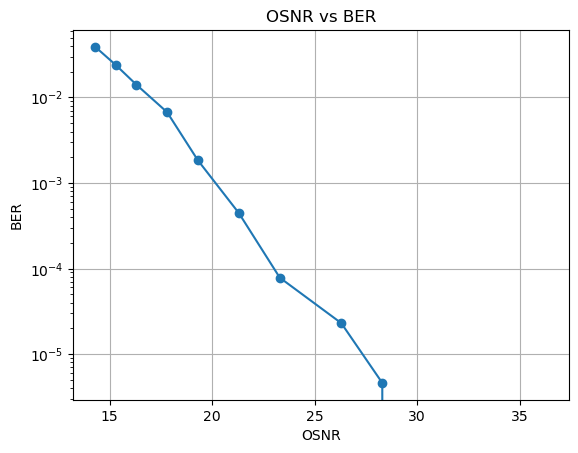

In [10]:
plt.plot(OSNR, ber, marker = 'o')
plt.title('OSNR vs BER')
plt.xlabel('OSNR')
plt.ylabel('BER')
plt.yscale('log')
plt.grid()
plt.show()